In [1]:
import sys
import os

# --- CONFIGURAZIONE PERCORSI ---
# Il percorso che hai appena trovato
PROJECT_ROOT = "/content/filippo/ML-SRT-SETI"
PROJECT_ROOT_LOCAL = "/home/filippo/TirocinioSETI/ML-SRT-SETI"

# 1. Verifica di sicurezza
if not os.path.exists(PROJECT_ROOT_LOCAL):
    raise FileNotFoundError(f"Attenzione! Non trovo la cartella: {PROJECT_ROOT_LOCAL}")

# 2. Spostiamo la 'Working Directory' lì
# Così quando fai np.load("data/processed/...") lui parte dalla root corretta
os.chdir(PROJECT_ROOT_LOCAL)

# 3. Aggiungiamo la cartella a Python per gli import
# Questo permette di fare 'from src import models' anche se il notebook non è lì fisicamente
if PROJECT_ROOT_LOCAL not in sys.path:
    sys.path.append(PROJECT_ROOT_LOCAL)

print(f"✅ Setup Completato!")
print(f"   Directory di lavoro: {os.getcwd()}")

✅ Setup Completato!
   Directory di lavoro: /home/filippo/TirocinioSETI/ML-SRT-SETI


In [4]:
%matplotlib inline

Avvio test generazione dati...
Parametri: SNR=(25, 40), Drift=(2.0, 6.0) Hz/s

--- INFO BATCH ---
Shape Input (X): (4, 6, 16, 512, 1)
Shape Labels (Y): (4,)
Valori min/max nel batch: 0.0000 - 1.0000
Labels nel batch: [1 0 1 0]


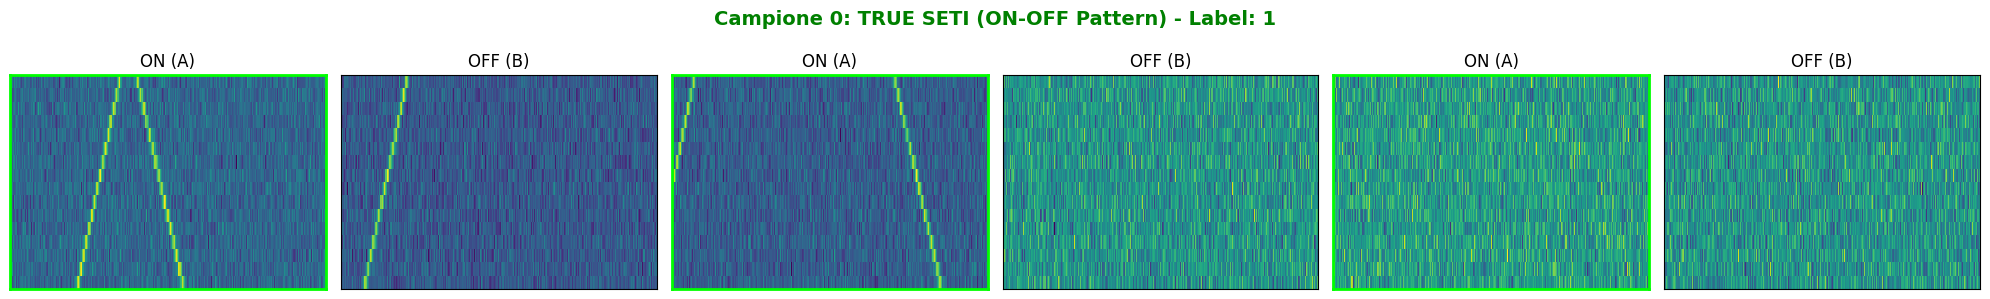

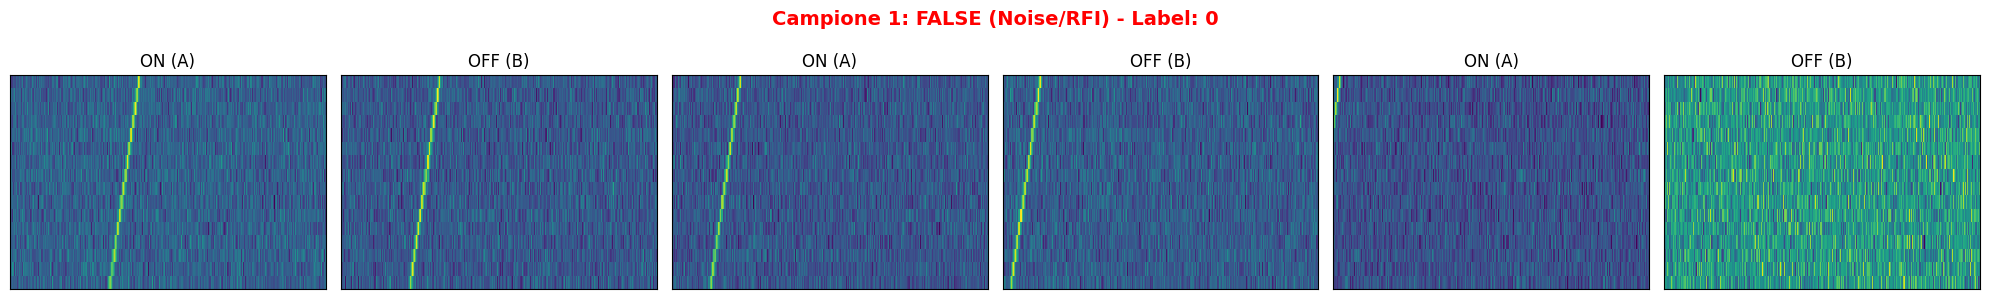

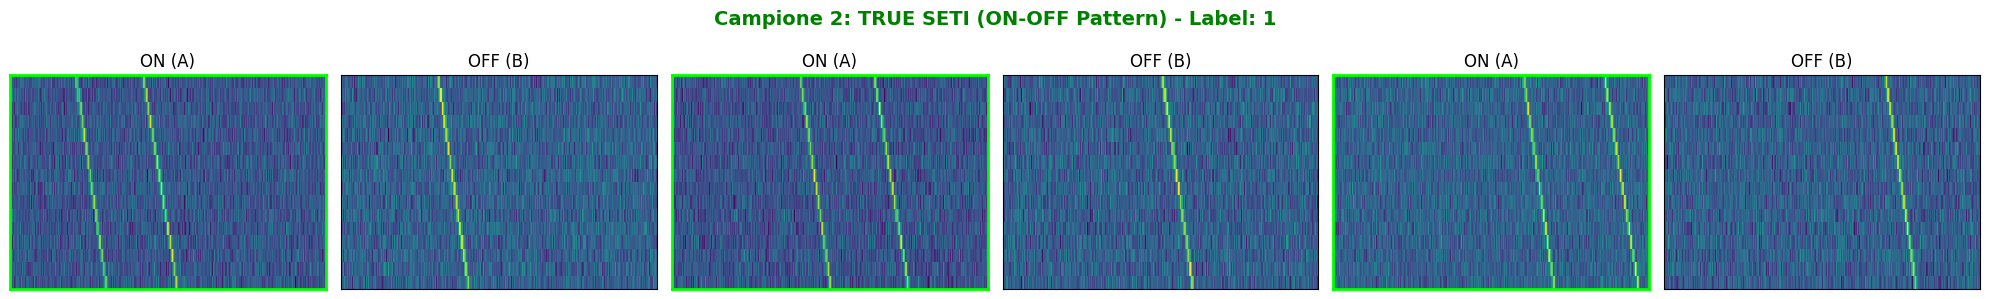

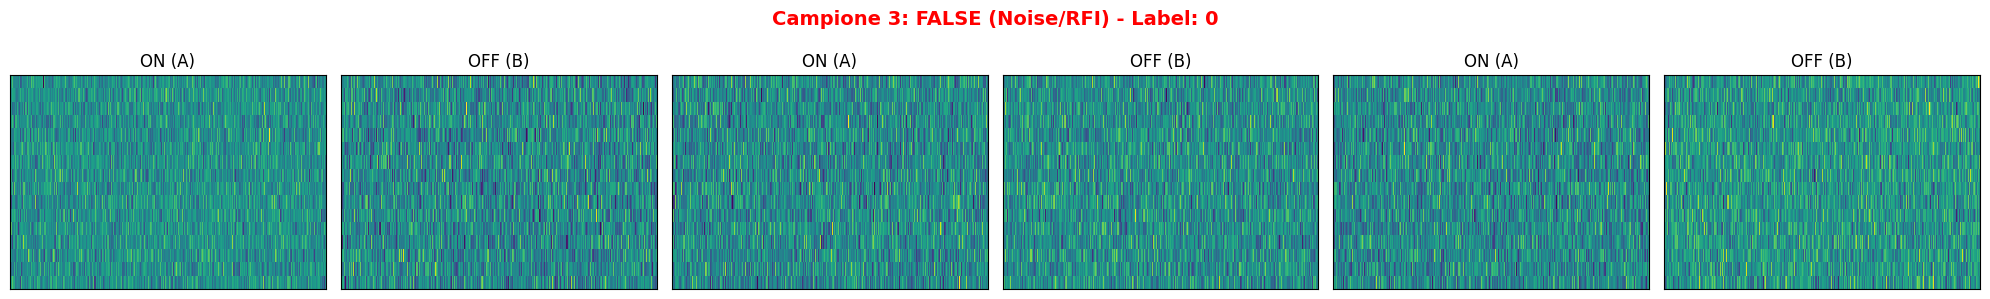

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from src.generator import SetigenGenerator

# --- CONFIGURAZIONE DEL TEST ---
BATCH_SIZE = 4
SNR_RANGE = (25, 40) # SNR alto per vederli bene ad occhio nudo
DRIFT_RANGE = (2.0, 6.0) # Drift evidente

print(f"Avvio test generazione dati...")
print(f"Parametri: SNR={SNR_RANGE}, Drift={DRIFT_RANGE} Hz/s")

# 1. Istanzia il Generatore
gen = SetigenGenerator(
    batch_size=BATCH_SIZE,
    snr_range=SNR_RANGE,
    drift_range=DRIFT_RANGE
)

# 2. Ottieni un batch dal tf.data.Dataset
dataset = gen.get_dataset()
# Preleviamo 1 solo batch per l'ispezione
iterator = iter(dataset)
batch_x, batch_y = next(iterator)

# Conversioni per numpy
images = batch_x.numpy() # Shape: (Batch, 6, 16, 512, 1)
labels = batch_y.numpy() # Shape: (Batch, )

print(f"\n--- INFO BATCH ---")
print(f"Shape Input (X): {images.shape}")
print(f"Shape Labels (Y): {labels.shape}")
print(f"Valori min/max nel batch: {np.min(images):.4f} - {np.max(images):.4f}")
print(f"Labels nel batch: {labels}")

# 3. Visualizzazione
def plot_cadence(cadence_data, label, index):
    """Visualizza i 6 pannelli di una singola cadenza."""
    # Rimuovi l'ultima dimensione del canale (1) -> (6, 16, 512)
    cadence = cadence_data[:, :, :, 0] 
    
    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    
    # Titolo: Verde se True (SETI), Rosso se False (RFI/Noise)
    color = 'green' if label == 1 else 'red'
    type_str = "TRUE SETI (ON-OFF Pattern)" if label == 1 else "FALSE (Noise/RFI)"
    fig.suptitle(f"Campione {index}: {type_str} - Label: {label}", color=color, fontweight='bold', fontsize=14)
    
    panel_names = ['ON (A)', 'OFF (B)', 'ON (A)', 'OFF (B)', 'ON (A)', 'OFF (B)']
    
    for i in range(6):
        ax = axes[i]
        # Aspect='auto' per adattare i 16 bin temporali ai 512 frequenziali
        im = ax.imshow(cadence[i], aspect='auto', interpolation='nearest', cmap='viridis')
        ax.set_title(panel_names[i])
        ax.set_xticks([]) # Nascondi tick frequenza per pulizia
        ax.set_yticks([])
        
        # Evidenzia i bordi dei pannelli ON se è un segnale SETI
        if label == 1 and i % 2 == 0:
            for spine in ax.spines.values():
                spine.set_edgecolor('lime')
                spine.set_linewidth(2)

    plt.tight_layout()
    plt.show()

# Plotta tutti i campioni del batch
for i in range(BATCH_SIZE):
    plot_cadence(images[i], labels[i], i)